# Implémentez un modèle de scoring


*Data source* : [Jeu de données d’articles](https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/Parcours_data_scientist/Projet+-+Impl%C3%A9menter+un+mod%C3%A8le+de+scoring/Projet+Mise+en+prod+-+home-credit-default-risk.zip)

---

## Rappel de la mission
Construire un modèle de scoring qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique.


In [1]:
#pip install catboost 

In [2]:
import pandas as pd
import seaborn as sns
import time, pickle


#Preprocessing, Upsampling, Model Selection, Model Evaluation
from sklearn.model_selection import train_test_split, StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score 
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from imblearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_val_predict, cross_val_score, learning_curve, cross_validate
from sklearn.feature_selection import RFECV

import warnings
warnings.filterwarnings("ignore")

In [3]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [4]:
plt.style.use('fivethirtyeight')
plt.rcParams.update(
    {
     'xtick.labelsize':15,
     'ytick.labelsize':15,
     'axes.labelsize': 15,
     'legend.fontsize': 15,
     'axes.titlesize':15,
     'axes.titleweight':'bold',
     'axes.titleweight':'bold'
    })

In [5]:
data_train = pd.read_csv(('data_train.csv'),index_col='SK_ID_CURR', encoding ='utf-8')
#data_train.drop('SK_ID_CURR', axis=1, inplace=True)
data_train.shape

(307511, 309)

In [6]:
TARGET = pd.read_csv('TARGET.csv', index_col='SK_ID_CURR')
TARGET.shape

(307511, 1)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(data_train.values, TARGET.values, test_size=0.3, random_state=42)

In [8]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((215257, 309), (92254, 309), (215257, 1), (92254, 1))

### **Baseline model - Logistic Regression**
Le projet consiste à mieux comprendre le défaut de crédit rencontré chez certain client, l'anticiper, l'estimer, etc… La prédiction peut se résumer par une sortie binaire, une acceptation de crédit, ou un refus de crédit. Afin d'avoir une première idée des performances possibles, la modélisation par régression logistique permettra d'obtenir une baseline.

In [9]:
def afficher_matrice_confusion(y_true, y_pred, title):

    plt.figure(figsize=(6, 4))

    cm = confusion_matrix(y_true, y_pred)
    
    #labels = ['Non défaillants', 'Défaillants']
    
    group_names = ['Vrai Neg','Faux Pos','Faux Neg','Vrai Pos']

    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
    
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    
    labels = np.asarray(labels).reshape(2,2)
    
    sns.heatmap(cm,
                #xticklabels=labels,
                #yticklabels=labels,
                annot=labels,
                fmt='',
                cmap=plt.cm.Blues)
    plt.title(f'Matrice de confusion de : {title}')
    plt.ylabel('Classe réelle')
    plt.xlabel('Classe prédite')
    plt.show()    

In [34]:

def plot_roc_curve(classifiers, X, y, n_splits=5):

    kf = KFold(n_splits=n_splits)    
    for name_clf, clf in classifiers.items():
        print(name_clf)
        tprs = []
        aucs = []
        mean_fpr = np.linspace(0, 1, 100)
        for i, (train, test) in enumerate(kf.split(X, y)):

            clf.fit(X.iloc[train, :], y.iloc[train])

            y_pred_grd = clf.predict_proba(X.iloc[test, :])[:, 1]
            fpr, tpr, thresholds = roc_curve(y.iloc[test], y_pred_grd)

            interp_tpr = np.interp(mean_fpr, fpr, tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            thresholds = auc(fpr, tpr)

            aucs.append(thresholds)

        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)
        plt.plot(mean_fpr, mean_tpr,
            label=name_clf + r'(AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2,
            alpha=.8)

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [10]:
from sklearn.linear_model import LogisticRegression

In [11]:
%%time
lr = LogisticRegression(C = 0.0001, max_iter=100)
lr.fit(X_train, y_train)
roc_auc = roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])
print('AUC : %0.4f' %roc_auc)
print(classification_report(y_test, lr.predict(X_test)))

AUC : 0.6939
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     84841
         1.0       0.00      0.00      0.00      7413

    accuracy                           0.92     92254
   macro avg       0.46      0.50      0.48     92254
weighted avg       0.85      0.92      0.88     92254

CPU times: user 4.67 s, sys: 507 ms, total: 5.18 s
Wall time: 947 ms


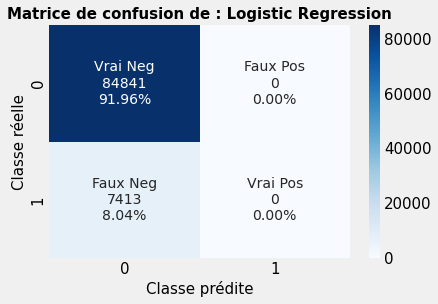

In [12]:
afficher_matrice_confusion(y_test,lr.predict(X_test),"Logistic Regression")

Notons un fort déséquilibre entre la précision trouvée pour la Target 0 (0.92) et la Target 1 (0). Pour rappel, l'échantillon de travail n'est pas équilibré, avec 92% des individus classés en modalité 0 et 8% en modalité 1, à savoir en défaut de paiement de crédit..

Il est donc intéressant de travailler cet Oversampling (ou suréchantillonnage en français)  en ajustant la distribution de classe de manière à avoir une répartition plus égalitaire.

**Oversampling Data Using SMOTE**

SMOTE with Imbalance Data using imblearn module



In [13]:
print("Label 1, Before using SMOTE: {} ".format(sum(y_train==1)))
print("Label 0, Before using SMOTE: {} ".format(sum(y_train==0)))

Label 1, Before using SMOTE: 17412 
Label 0, Before using SMOTE: 197845 


In [14]:
sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [15]:
print("Label 1, After using SMOTE: {}".format(sum(y_train_res==1)))
print("Label 0, After using SMOTE: {}".format(sum(y_train_res==0)))

Label 1, After using SMOTE: 197845
Label 0, After using SMOTE: 197845


In [16]:
%%time
lr = LogisticRegression(C = 0.0001, max_iter=100)
lr.fit(X_train_res, y_train_res)
roc_auc = roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])
print('AUC : %0.4f' %roc_auc)
print(classification_report(y_test, lr.predict(X_test)))

AUC : 0.7196
              precision    recall  f1-score   support

         0.0       0.96      0.67      0.79     84841
         1.0       0.15      0.65      0.24      7413

    accuracy                           0.67     92254
   macro avg       0.55      0.66      0.52     92254
weighted avg       0.89      0.67      0.75     92254

CPU times: user 11 s, sys: 2.4 s, total: 13.4 s
Wall time: 2.63 s


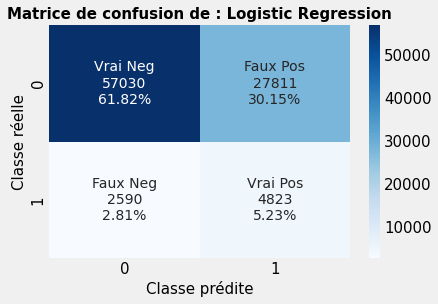

In [17]:
afficher_matrice_confusion(y_test,lr.predict(X_test),"Logistic Regression")

In [18]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


### **Gradient Boosting**

In [19]:
#Predictive Models
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

models = [
          CatBoostClassifier(),
          XGBClassifier()]

La fonction suivante ``train_models`` peut calculer les métriques auc, accuracy, f1, precision et recall. On peut la modifier selon les besoins attendus, il suffit de se référer aux [Scoring de Classification de Scikit-learn](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter).

In [20]:
def train_models(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    output = {
      'AUC': roc_auc_score(y_test, model.predict_proba(X_test)[:,1]),
      'Accuracy': accuracy_score(y_test, model.predict(X_test)),
      'Precision': precision_score(y_test, model.predict(X_test)),
      'Recall': recall_score(y_test, model.predict(X_test)),
      'F1': f1_score(y_test, model.predict(X_test))
      }
          
    return output

In [21]:
%%time

name = []
auc = []
accuracy = []
precision = []
recall = []
f1 = []
time_ = []

for model in models:
    start = time.time()
    results = train_models(model, X_train, X_test, y_train, y_test)

    name.append(type(model).__name__)
    auc.append(results['AUC'])
    accuracy.append(results['Accuracy'])
    precision.append(results['Precision'])
    recall.append(results['Recall'])
    f1.append(results['F1'])
    time_.append(time.time()-start)

#Initialise data of lists
base_models = pd.DataFrame(data=[name, auc, accuracy, precision, recall, f1, time_]).T
base_models.columns = ['Model', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1', 'Time']
base_models.sort_values('AUC', ascending=False, inplace=True)

Learning rate set to 0.102119
0:	learn: 0.5951027	total: 98.2ms	remaining: 1m 38s
1:	learn: 0.5173330	total: 124ms	remaining: 1m 1s
2:	learn: 0.4583927	total: 152ms	remaining: 50.4s
3:	learn: 0.4142216	total: 179ms	remaining: 44.5s
4:	learn: 0.3786435	total: 208ms	remaining: 41.3s
5:	learn: 0.3522216	total: 235ms	remaining: 38.9s
6:	learn: 0.3310012	total: 268ms	remaining: 38.1s
7:	learn: 0.3169555	total: 299ms	remaining: 37.1s
8:	learn: 0.3039291	total: 330ms	remaining: 36.4s
9:	learn: 0.2935896	total: 357ms	remaining: 35.3s
10:	learn: 0.2865022	total: 381ms	remaining: 34.3s
11:	learn: 0.2807593	total: 406ms	remaining: 33.4s
12:	learn: 0.2752659	total: 432ms	remaining: 32.8s
13:	learn: 0.2712494	total: 457ms	remaining: 32.2s
14:	learn: 0.2680326	total: 486ms	remaining: 31.9s
15:	learn: 0.2653373	total: 513ms	remaining: 31.5s
16:	learn: 0.2631955	total: 537ms	remaining: 31.1s
17:	learn: 0.2612750	total: 568ms	remaining: 31s
18:	learn: 0.2594916	total: 594ms	remaining: 30.7s
19:	learn: 

In [22]:
base_models

,Model,AUC,Accuracy,Precision,Recall,F1,Time
0,CatBoostClassifier,0.778378,0.919754,0.507163,0.047754,0.087289,69.866343
1,XGBClassifier,0.770294,0.919006,0.466363,0.055173,0.098673,47.836451


Nous allons comparer une nouvelle fois nos modèles, cette fois-ci l'entrainement se fera avec les données SMOTE.

In [23]:
%%time

name = []
auc = []
accuracy = []
precision = []
recall = []
f1 = []
time_ = []

for model in models:
    start = time.time()
    results = train_models(model, X_train_res, X_test, y_train_res, y_test)

    name.append(type(model).__name__)
    auc.append(results['AUC'])
    accuracy.append(results['Accuracy'])
    precision.append(results['Precision'])
    recall.append(results['Recall'])
    f1.append(results['F1'])
    time_.append(time.time()-start)

#Initialise data of lists
models_res = pd.DataFrame(data=[name, auc, accuracy, precision, recall, f1, time_]).T        
models_res.columns = ['Model', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1', 'Time']
models_res.sort_values('AUC', ascending=False, inplace=True)

Learning rate set to 0.132436
0:	learn: 0.6005486	total: 92.2ms	remaining: 1m 32s
1:	learn: 0.5103035	total: 173ms	remaining: 1m 26s
2:	learn: 0.4693807	total: 257ms	remaining: 1m 25s
3:	learn: 0.4228259	total: 339ms	remaining: 1m 24s
4:	learn: 0.4031798	total: 406ms	remaining: 1m 20s
5:	learn: 0.3775609	total: 485ms	remaining: 1m 20s
6:	learn: 0.3548460	total: 555ms	remaining: 1m 18s
7:	learn: 0.3253556	total: 626ms	remaining: 1m 17s
8:	learn: 0.3088210	total: 695ms	remaining: 1m 16s
9:	learn: 0.2975454	total: 768ms	remaining: 1m 16s
10:	learn: 0.2887235	total: 848ms	remaining: 1m 16s
11:	learn: 0.2799356	total: 925ms	remaining: 1m 16s
12:	learn: 0.2654292	total: 997ms	remaining: 1m 15s
13:	learn: 0.2600498	total: 1.09s	remaining: 1m 16s
14:	learn: 0.2536073	total: 1.16s	remaining: 1m 16s
15:	learn: 0.2502120	total: 1.26s	remaining: 1m 17s
16:	learn: 0.2472359	total: 1.34s	remaining: 1m 17s
17:	learn: 0.2371546	total: 1.42s	remaining: 1m 17s
18:	learn: 0.2294912	total: 1.49s	remaining

In [24]:
models_res

,Model,AUC,Accuracy,Precision,Recall,F1,Time
0,CatBoostClassifier,0.770409,0.919537,0.493766,0.05342,0.096409,120.427102
1,XGBClassifier,0.752217,0.918193,0.429474,0.055038,0.097573,98.906858


In [35]:
X_test = pd.DataFrame(X_test, columns=data_train.columns) # returning standardized to dataframe with column names

In [36]:
import xgboost as xgb
cls = xgb.XGBClassifier(use_label_encoder=False)
cls.fit(X_train_res, y_train_res)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [37]:
#On sauvegarde notre modèle au format pickle
with open("best_model_XGBoost_pickle.pkl", 'wb') as file:  
    pickle.dump(XGBClassifier, file)

In [38]:
import shap

In [39]:
#On importe le modèle shap pour l'interprétabilité de notre modèle
shap.initjs()
explainer = shap.TreeExplainer(cls)
shap_values = explainer.shap_values(X_test)

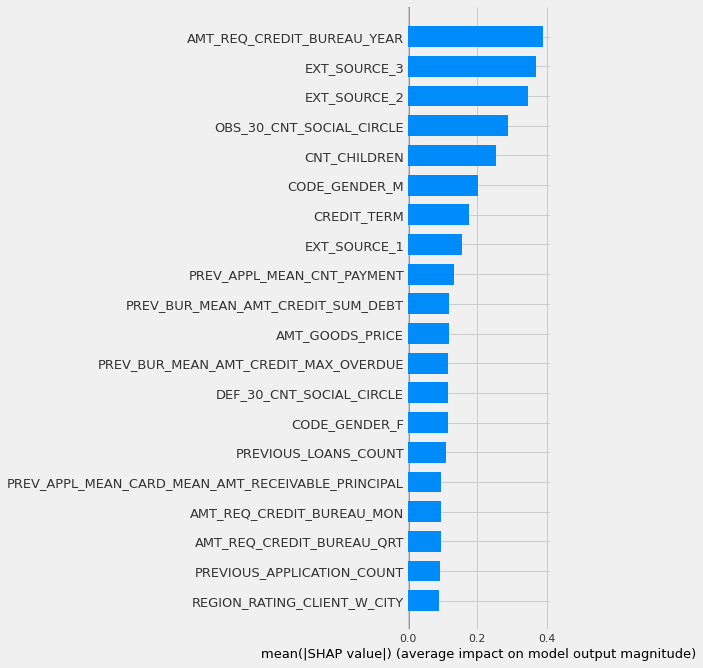

In [40]:
#On trace l'importance des variables de notre modèle
fig = shap.summary_plot(shap_values, X_test, plot_type="bar")

In [41]:
def plot_shape_values(model, x_test):
    '''
    Affiche les SHAPE VALUES.
    Parameters
    ----------
    model: le modèle de machine learning, obligatoire
    x_test :le jeu de test de la matrice X, obligatoire
    Returns
    -------
    None.
    '''
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(x_test)

    shap.summary_plot(shap_values, x_test, plot_type="bar")

    shap.summary_plot(shap_values, x_test)

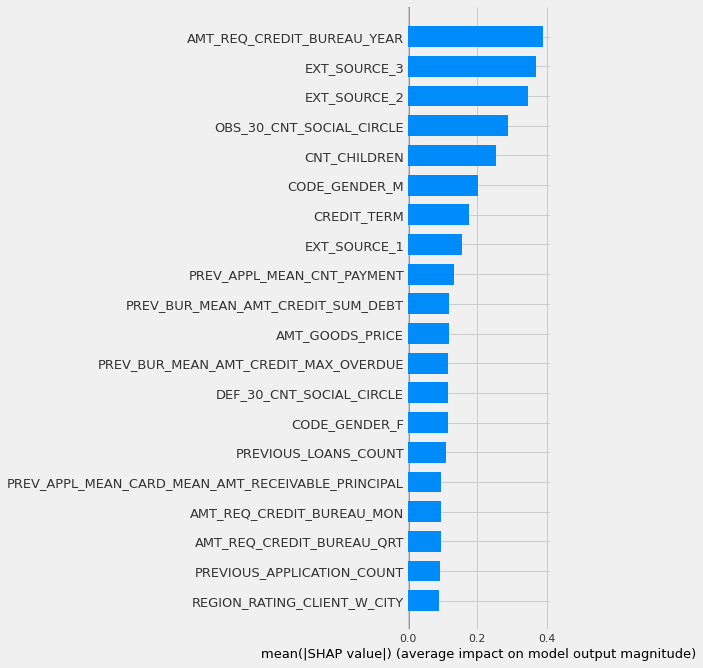

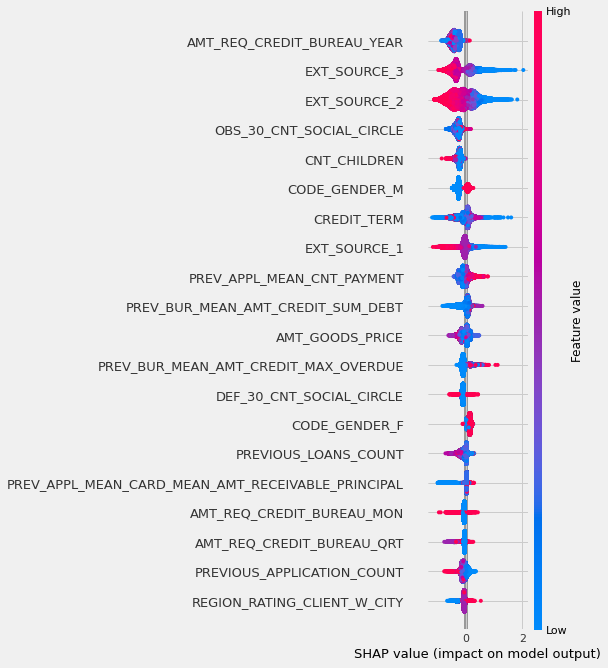

In [42]:
plot_shape_values(cls, X_test)

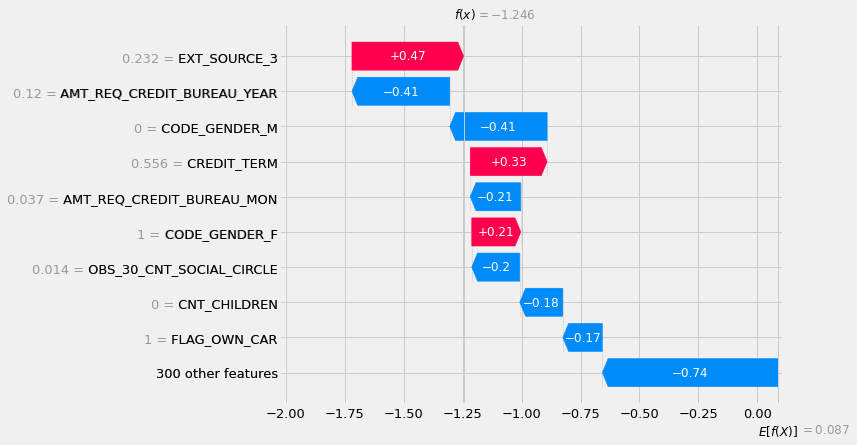

In [46]:
#On trace le waterfall d'un client eligible
shap.waterfall_plot(shap.Explanation(values=shap_values[2,:],
                                     base_values=explainer.expected_value,
                                     data=X_test.iloc[2,:],
                                     feature_names=X_test.columns.tolist()),max_display=10)